# Data Curation for DAPT (Domain Adaptive Pre-Training)

## Learning Goals and Datasets

This playbook aims to demonstrate how to curate data from various data sources to customize foundation models through domain-adaptive pre-training and improve performance on domain-specific tasks.

In this playbook, we will leverage chip domain/hardware datasets from open-source GitHub repositories (`./sources/github_repos.jsonl`), wiki URLs (`./sources/wikipedia_urls.jsonl`), and academic papers(`./sources/arxiv_urls.jsonl`).

This playbook utilizes specific tools and techniques. First, we convert all files to Txt format (if not already in Txt), compress files on disk, add metadata, and convert them to JSON (`./data/raw/`). Then, we leverage [NeMo Curator](https://github.com/NVIDIA/NeMo-Curator/tree/main) to mine high-quality text at scale from a massive code-generation corpus. [NeMo Curator](https://github.com/NVIDIA/NeMo-Curator/tree/main), built on Dask and RAPIDS, is instrumental in scaling data curation and providing GPU acceleration. We use its capabilities to extract text, identify code file types, fix unicode errors, filter quality through heuristics, deduplicate, and redact personal information. We finally also provide steps to blend and shuffle data sources for continued pre-training.

## NeMo Tools and Resources

* [NeMo-Curator GitHub repo](https://github.com/NVIDIA/NeMo-Curator/tree/main)

## Software Requirements
* This playbook has been tested on: nvcr.io/nvidia/nemo:24.03.01.framework. It is expected to work similarly on other environments. Within the container, from the NeMo-Curator directory install using `pip install --extra-index-url https://pypi.nvidia.com ".[cuda12x]"`
* NeMo Curator currently requires Python 3.10 and the GPU accelerated modules require CUDA 12 or above installed in order to be used.

## Hardware Requirements
* This playbook can run on CPUs or GPUs. For GPUs, this playbook has been tested on minimum 1xA100 80G

### Overview of steps involved: 
In this notebook, we will use the datasets in the `dapt-curation/code/data` folder to illustrate data curation through this pipeline. Specifically sample data collected in:
* `./data/raw/github` (we clone github repos, extract text from each file and convert to jsonl)
* `./data/raw/arxiv_pdfs` (we extract data from pdfs, convert to txt and store as jsonl files)
* `./data/raw/wikipedia` (we extract data from htmls, parse, convert to txt and store as json files)

The notebook follows the steps below:<br>
- Step 1: Install requirements and import libraries<br>
- Step 2: Download the data from online sources (Github repos, wiki urls, arxiv pdfs), extract metadata and convert to JSONL<br>
- Step 3: Load the dataset <br>
- Step 4: Examine the file types and sizes (optional) <br>
- Step 5: Run the data curation pipeline with with Nemo Curator<br>
    - File type identification and separation
    - Document-level exact deduplication
    - Heuristic-based quality filtering (Number of lines, worc count, top N-grams, etc.)
    - Fix unicode errors via ftfy
    - PII redaction
- Step 6: Save the filtered and curated data <br>
- Step 8: Blend datasets and shuffle

## Step 1: install the prerequisites and import the required modules

In [1]:
! pip install -r requirements.txt
# uninstall all versions of opencv
! pip uninstall --yes $(pip list --format=freeze | grep opencv)

# remove the stale cv2 dist-packages directory
# (pay attention to your location and python version)
! rm -rf /usr/local/lib/python3.10/dist-packages/cv2/
! pip install opencv-python-headless

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.6/653.6 kB 33.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 137.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


  Preparing metadata (setup.py) ... done


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 249.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 242.3 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 256.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 109.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 286.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 295.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 168.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 149.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 326.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 144.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.4/466.4 kB 149.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 207.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 115.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 117.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 316.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.0/220.0 kB 338.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.3/309.3 kB 325.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 123.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 292.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 276.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 278.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 121.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 284.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 300.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 127.3 MB/s eta 0:00:00
  Created wheel 


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python -m pip install --upgrade pip
Found existing installation: opencv 4.7.0
Uninstalling opencv-4.7.0:
  Successfully uninstalled opencv-4.7.0
Found existing installation: opencv-python 4.10.0.84
Uninstalling opencv-python-4.10.0.84:
  Successfully uninstalled opencv-python-4.10.0.84
Found existing installation: opencv-python-headless 4.9.0.80
Uninstalling opencv-python-headless-4.9.0.80:
  Successfully uninstalled opencv-python-headless-4.9.0.80
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 83.9 MB/s eta 0:00:0000:01:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
img

In [1]:
from nemo_curator.utils.distributed_utils import get_client
from nemo_curator.utils.file_utils import get_all_files_paths_under
from nemo_curator.datasets import DocumentDataset
from nemo_curator.utils.script_utils import add_distributed_args, parse_client_args
from nemo_curator import ScoreFilter, Sequential
from nemo_curator.utils.file_utils import get_all_files_paths_under, separate_by_metadata
from modifiers import QuotationUnifier
from utils import clean_and_unify, filter_txt, filter_code, filter_code_dataset, redact, dedupe, redact_pii
from utils import filter_txt_lines, filter_code_lines
import os
import shutil
import nemo_curator as nc

from downloaders import download_wikipedia_sources, download_github_sources, download_pdf_sources

# Arguments required for dask client 
#see nemo_curator.utils.script_utils.add_distributed_args
class Args:
    n_workers = os.cpu_count()
    threads_per_worker = 1
    protocol = 'tcp'
    files_per_partition = 2
    device = 'gpu' #or 'cpu'
    scheduler_address = None
    scheduler_file = None
    
args = Args()
args.n_workers = min(args.n_workers, 2)

# Initialize the Dask cluster.
client = get_client(**parse_client_args(args))

# Step 2: download the data from online sources and convert to JSONL

In [2]:
wikipedia_dir = download_wikipedia_sources("sources/wikipedia_urls.jsonl",limit=100)
pdf_dir = download_pdf_sources("sources/arxiv_urls.jsonl")
github_dir = download_github_sources("sources/github_repos.jsonl", limit=10)

Download directory:  /workspace/ndc_dapt_playbook/tutorials/dapt-curation/code/data/raw/wikipedia
['https://arxiv.org/pdf/2406.03636.pdf', 'https://arxiv.org/pdf/2406.03003.pdf', 'https://arxiv.org/pdf/2406.00115.pdf', 'https://arxiv.org/pdf/2406.00602.pdf', 'https://arxiv.org/pdf/2406.03227.pdf', 'https://arxiv.org/pdf/2406.03088.pdf', 'https://arxiv.org/pdf/2406.01698.pdf', 'https://arxiv.org/pdf/2406.00858.pdf', 'https://arxiv.org/pdf/2406.00360.pdf', 'https://arxiv.org/pdf/2406.03165.pdf']


# Step 3: load the dataset

In [3]:
print("Reading the data...")
wiki_files = get_all_files_paths_under(wikipedia_dir)
pdf_files = get_all_files_paths_under(pdf_dir)
code_files = get_all_files_paths_under(github_dir)

text_files = wiki_files + pdf_files

orig_dataset_text = DocumentDataset.read_json(text_files, add_filename=True)
orig_dataset_code = DocumentDataset.read_json(code_files, add_filename=True)

len(orig_dataset_text.df) + len(orig_dataset_code.df)

Reading the data...
Reading 110 files
Reading 6 files


15204

# Step 4: Examine the file types and data sizes

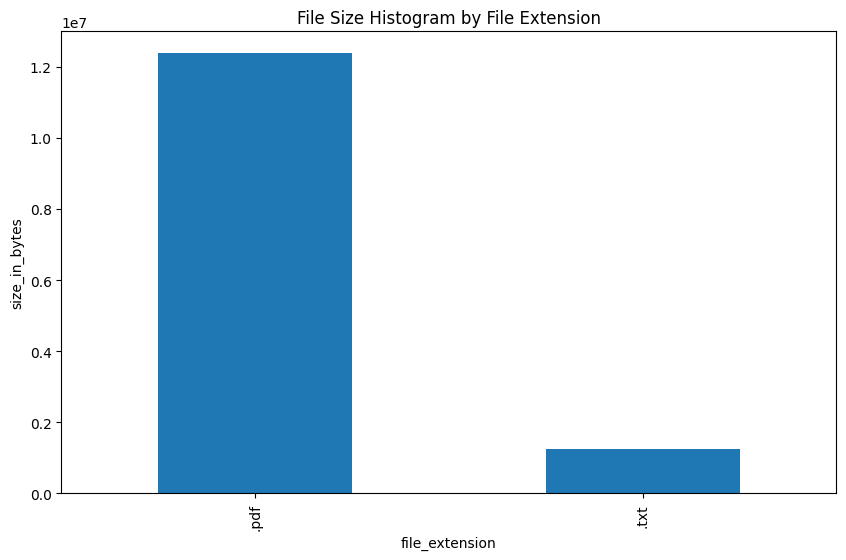

In [4]:
import matplotlib.pyplot as plt
orig_df = orig_dataset_text.df.compute()
orig_df = orig_df.reset_index()

# Create a histogram for different file types -text
fig, ax = plt.subplots(figsize=(10, 6))
orig_df.groupby("file_extension")["size_in_bytes"].sum().plot(kind="bar", ax=ax)
ax.set_xlabel("file_extension")
ax.set_ylabel("size_in_bytes")
ax.set_title("File Size Histogram by File Extension")

# Save the histogram to a file
fig.savefig("./file_size_histogram_txt.png", bbox_inches="tight")
# print(os.path.dirname(input_file)+'/file_size_histogram.png')
# Display the histogram
plt.show()

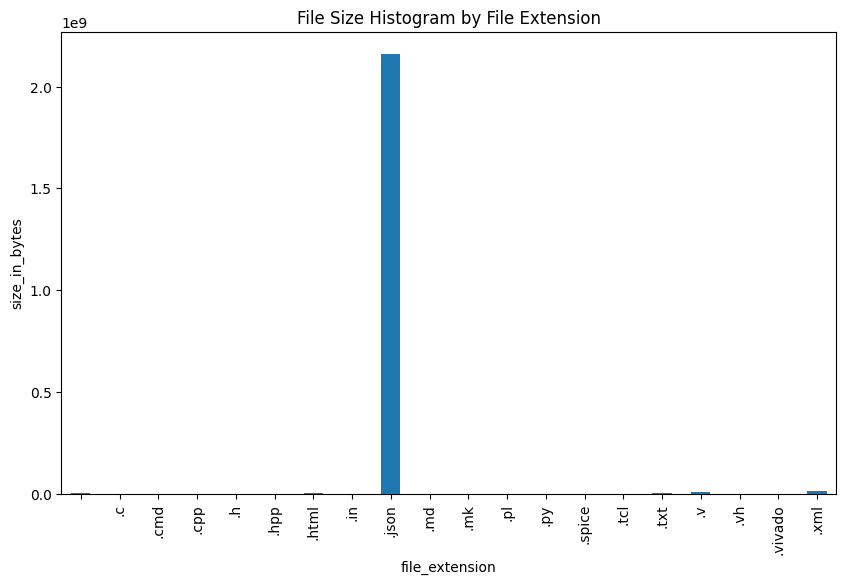

In [5]:
orig_df = orig_dataset_code.df.compute()
orig_df = orig_df.reset_index()

# Create a histogram for different file types - code
fig, ax = plt.subplots(figsize=(10, 6))
orig_df.groupby("file_extension")["size_in_bytes"].sum().plot(kind="bar", ax=ax)
ax.set_xlabel("file_extension")
ax.set_ylabel("size_in_bytes")
ax.set_title("File Size Histogram by File Extension")

# Save the histogram to a file
fig.savefig("./file_size_histogram_code.png", bbox_inches="tight")
# print(os.path.dirname(input_file)+'/file_size_histogram.png')
# Display the histogram
plt.show()

# Step 5: run the data curation pipeline

In [6]:
print(f"Running curation pipeline on './data/raw'...")

# Define data curation steps for text and pdf files
curation_steps_text = Sequential(
    [
        dedupe,
        filter_txt_lines,
        filter_txt,
        clean_and_unify,
#         redact_pii, #Not needed for non-code files
    ]
)

# Define data curation steps for code files
curation_steps_code = Sequential(
    [
        dedupe,
        filter_code_lines,
        filter_code,
        clean_and_unify,
#         redact_pii
    ]
)

print("Executing the pipeline...")
dataset_text = curation_steps_text(orig_dataset_text)
dataset_text = dataset_text.persist() 

print(f"Original dataset length for text files: {len(orig_dataset_text.df)}")
print(f"After dataprep: {len(dataset_text.df)}")

dataset_code = curation_steps_code(orig_dataset_code)
dataset_code = dataset_code.persist()

print(f"Original dataset length for code files: {len(orig_dataset_code.df)}")
print(f"After dataprep: {len(dataset_code.df)}")


Running curation pipeline on './data/raw'...
Executing the pipeline...
Original dataset length for text files: 110
After dataprep: 110
Original dataset length for code files: 15096
After dataprep: 14849


# Step 6: save the filtered and curated data

In [6]:
print("Writing the results to disk...")
output_dir = "./data/curated/"

#save filtered and cleaned datasets
# Overwrite existing files and save all jsonl in the curated directory.
out_path = os.path.join(output_dir, "json")
if os.path.isdir(out_path):
    shutil.rmtree(out_path)
os.makedirs(out_path, exist_ok=True)
dataset_text.to_json(out_path, write_to_filename=True)
dataset_code.to_json(out_path, write_to_filename=True)

# Split the dataset by file category and save curated files
separated_data_text = separate_by_metadata(dataset_text.df,out_path, 'category').compute()
separated_data_code = separate_by_metadata(dataset_code.df,out_path, 'category').compute()

# # Overwrite existing files and save to all parquet format in the curated directory if needed 
out_path = os.path.join(output_dir, "parquet")
if os.path.isdir(out_path):
    shutil.rmtree(out_path)
os.makedirs(out_path, exist_ok=True)
dataset_text.to_parquet(out_path, write_to_filename=True)
dataset_code.to_parquet(out_path, write_to_filename=True)

client.close()

Writing the results to disk...
Writing to disk complete for 110 partitions


/usr/local/lib/python3.10/dist-packages/nemo_curator/utils/distributed_utils.py:391: UserWarning: Empty partition found
  warnings.warn(f"Empty partition found")
/usr/local/lib/python3.10/dist-packages/nemo_curator/utils/distributed_utils.py:391: UserWarning: Empty partition found
  warnings.warn(f"Empty partition found")


Writing to disk complete for 14849 partitions


/usr/local/lib/python3.10/dist-packages/nemo_curator/utils/distributed_utils.py:391: UserWarning: Empty partition found
  warnings.warn(f"Empty partition found")


Writing to disk complete for 110 partitions


/usr/local/lib/python3.10/dist-packages/nemo_curator/utils/distributed_utils.py:391: UserWarning: Empty partition found
  warnings.warn(f"Empty partition found")


Writing to disk complete for 14849 partitions


# Step 7: blend datasets and shuffle

In [13]:
root_path = os.path.join(output_dir+'json')
dataset_paths = [root_path+"/CPP", root_path+"/VerilogVHDL", root_path+"/text", root_path+"/Python"]
dataset_weights = [1.0, 4.0, 4.0, 1.0]
target_size = 20
output_path = output_dir+"/data_blended"
if os.path.isdir(output_path):
    shutil.rmtree(output_path)
os.makedirs(output_path)
# Blend the datasets
datasets = [DocumentDataset.read_json(path) for path in dataset_paths]
blended_dataset = nc.blend_datasets(target_size, datasets, dataset_weights)

shuffle = nc.Shuffle(seed=42)
blended_dataset = shuffle(blended_dataset)

# Save the blend
blended_dataset.to_json(output_path)

Reading 3 files
Reading 6 files
Reading 114 files
Reading 4 files
Writing to disk complete for 20 partitions


### We are now ready to use these curated data files for continued pre-training of LLMs¶